# Density estimation for continuous distributions
Author : Laurène David <br>
Date : 17/02/2023

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

Generate data with joint normal distribution <br>
After discussing with the researchers on 16/02, the next step would be to generate data using an "appropriate" function for the paper's use case. 

In [4]:
mean = [0,0]
cov = [[1, 0], [0, 100]]
X = np.random.multivariate_normal(mean, cov, 5000)

In [ ]:
# def density_funs(x,y,K):
#     add = 0
#     for k in range(K):
#         if (x in range(0,1)) and (y in range(0,1)):
#             add += 1
    
#     return add 


### Algorithm 1 : estimate probability matrix P for discrete distribution

The original algorithm sent by the researchers 

In [5]:
def our_algo(n,Y1,Y2,alpha,cstar,Cbar):
    (d1,d2) = np.shape(Y1)
    d = max(d1,d2)
    
    if (n <= d*np.log(d)):
        print("test 1")
        return((Y1+Y2)/2)
      
    else:
        res = np.zeros((d1,d2))
        T = int(np.log(d)/np.log(2))
        p = np.sum(Y1, axis=1)
        q = np.sum(Y1, axis=0)
        print("Y1 :",Y1)
        print("p :",p)
        print("q :",q)

        for t in range(T+1):
            if (t<T):
                I = np.argwhere((p <= 2**(-t)) & (p > 2**(-t-1)))
            else: 
                I = np.argwhere((p <= 2**(-t)))
                
            for u in range(T+1):
                if (u<T):
                    J = np.argwhere((q <= 2**(-u)) & (q > 2**(-u-1)))
                else: 
                    J = np.argwhere(q <= 2**(-u))
                #M = np.zeros(np.shape(Y2))  
                M = np.zeros((len(I),len(J)))
                
                print("I :",I)
                print("J :",J)

                for i in range(len(I)):
                    for j in range(len(J)):
                        M[i,j] = Y2[I[i],J[j]]
                
                if (np.sum(M) < 2*Cbar*alpha*np.log(d)/(n*np.log(2))):
                    print("test 2")
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = Y2[I[i],J[j]]
                else:
                    #print((t,u))
                    tau = np.log(d) * np.sqrt(cstar * 2**(1-min(t,u))/n)
                    U,s,Vh = np.linalg.svd(M)
                    l = len(s[s>=tau])  #truncation/threshold of SVD with s (select s values > tau)
                    #l = 5
                    H = np.dot(U[:,:l]*s[:l], Vh[:l,:])
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = H[i,j]

                    print("res :",res)
        
        
        #return(res/np.sum(res))
        return(res)

### Algorithm 3 : One-dimensional density estimation procedure 

My attempt to implement the paper's third algorithm. <br>
The end goal would be to include both Algorithm 2 and 3 into the same function. <br>
I think that I can optimize a little this algorithm in a second step.


In [6]:
def our_algo_3(n,Z,L,C):
    """
    The goal of this function is to generate a one-dimensional density estimator for continuous distributions.

    parameters :
    ----

    n : int 
    sample size 

    Z : numpy.ndarray
    A 1d array generated by a density function for continuous distributions

    L : int (or float ?)
    a constant 

    C : float
    a large absolute constant


    Return :
    ---
    f_2 : function
    one-dimensional density function estimator

    
    """
    
    r = np.min(Z)
    R = np.max(Z)
    h = C/(n**(-1/3)*np.sqrt(L))

    if (R - r < n**(-1/3)*L**(-1/2)):

        def f_1(x):
            if x<=r and x>=R :
                return 1/(R-r)
            else :
                return 0
        
        return f_1

    else:
        N = np.zeros((int(1/h),))
        
        for j in range(int(1/h)):
            a = j*h
            b = (j+1)*h
            N[j] = len(np.argwhere((Z>=a) & (Z<b)))

        def f_2(x):
            s = 0
            for j in range(int(1/h)):
                if x>=j*h and x<=(j+1)*h:
                    s += N[j]
                #else:
                #    s += 0

            return (1/h)*s
        
    return f_2

In [7]:
#fun = our_algo_3(np.random.rand(10,1),20,0.5)

### Algorithm 2 : Two-dimensional density estimation procedure 

My attempt at implementing the second algorithm.

In [8]:
def our_algo_2(n,X,alpha,L,C,Cbar,cstar):

    """
    The goal of this function is to generate a two-dimensional probability density estimator for continuous distributions.

    Parameters :
    ----

    n : int 
    sample size 

    X : numpy.ndarray
    A 2d array generated by a density function for continuous distributions
    
    alpha : float
    tuning parameter 

    L : int (or float ?)
    a constant 

    C : float
    a large absolute constant

    Cbar : float 
    tuning parameter

    cstar : float
    a constant 


    Return :
    ---
    f_2 : function
    one-dimensional density function estimator 

    
    """

    pi_1 = list(map(lambda x: x[0] ,X))
    pi_2 = list(map(lambda x: x[1] ,X))
    h = C/(n**(-1/3)*np.sqrt(L))

    if (np.max(pi_1)-np.min(pi_1) < n**(1/3)*L**(-1/2)):
        g = our_algo_3(n,pi_2,L,C)
        
        def f_1(x,y):
            if (x>=np.min(pi_1)) and (x<=np.max(pi_1)):
                return (1/(np.max(pi_1)-np.min(pi_1)))*g(y)
            else:
                return 0
        
        return f_1
    

    if (np.max(pi_2)-np.min(pi_2) < n**(1/3)*L**(-1/2)):
        g = our_algo_3(n,pi_1,L,C)
        
        def f_2(x,y):
            if (x>=np.min(pi_2)) and (x<=np.max(pi_2)):
                return (1/(np.max(pi_2)-np.min(pi_2)))*g(x)
            else:
                return 0
         
        return f_2
    
    else:
        #print("h :",h)
        N_1 = np.zeros((int(1/h),int(1/h))) 
        N_2 = np.zeros((int(1/h),int(1/h))) 
        
        for i in range(int(1/h)):
            a_i = i*h 
            b_i = (i+1)*h

            for j in range(int(1/h)):
                a_j = j*h
                b_j = (j+1)*h
                #print("a_j :",a_j)

                N_1[i,j] = np.sum(len(np.argwhere((X[:int(n/2),0]>=a_i) & (X[:int(n/2),0]<b_i) & (X[:int(n/2),1]>=a_j) & (X[:int(n/2),1]<b_j)))) 
                N_2[i,j] = np.sum(len(np.argwhere((X[int(n/2):,0]>=a_i) & (X[int(n/2):,0]<b_i) & (X[int(n/2):,1]>=a_j) & (X[int(n/2):,1]<b_j))))
        
        P = our_algo(n,N_1,N_2,alpha,cstar,Cbar)
        #print("P :",P)
    
    def f_3(x,y):
        s = 0
        for i in range(int(1/h)):
            for j in range(int(1/h)):
                if (x in range(i*h,(i+1)*h)) and (y in range(j*h,(j+1)*h)):
                     s += P[i,j]
                
        return (1/h**2)*s
    
    return f_3
            

Test algorithm for continuous distributions (algorithm 2/3)

In [10]:
Cbar = .5
alpha = .1
cstar= alpha/10
L = 1
C = .005 
n = X.shape[0]

funs_test = our_algo_2(n,X,alpha,L,C,Cbar,cstar)

In [11]:
x = np.linspace(0,1)
y = np.linspace(0,1)

test_density = list(map(funs_test,x,y))
#funs_test(x,y)

Plot of the two dimensional estimated density function with the first coordinate x

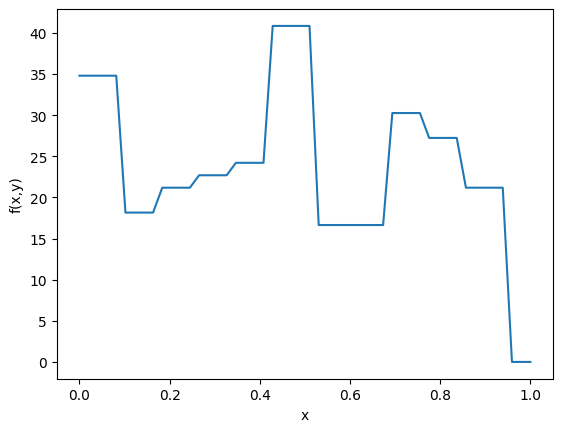

In [12]:
plt.plot(x,test_density)
plt.xlabel("x");
plt.ylabel("f(x,y)");